# KELT-16b : Broad analysis with recent TESS data
### June Parsons | 20191203

---

![KELT-16b ](KELT_16b_RVB_darkBG_final_DNE.png)

---

## Abstract
Kelt-16b is an ultra-short period hot-Jupiter exoplanet located 399(+/-19)pc away. [1] Its discovery by the KELT (Kilodegree Extremely Little Telescope) survey in 2016 [2] sparked much interest in future observation endevours of direct exoplanet atmosphere study that may involve HST or the everlate JWST due to its size, temperature, period, and depth. [1, 3] In this work we analyze KELT-16b photometry from TESS( Transiting Exoplanet Survey Satellite ) sector 15 data released 20190921 [4] to confirm its ultra short period is *P < 1* and verify other photometrically derivable qualities of KELT-16b. We found that KELT-16b has a period of 0.9634022521 days with a semi-major axis of 0.0203199166 +/- 0.0008087529  AU. The radius od KELT-16b is found to be 1.34677 +/- 0.06152  Jupiter radii. We go on to discuss future analysis, observations and motivations for the continued study of KELT-16b.


## Introduction
The TESS survey images each sector for 27 days while some sectors overlap resulting in increased observational time for the same part of the sky. Data is taken every 2 seconds and combined into 2-minute cadence files which are cropped to produce smaller 'stamp' images that are stored as a series in a data product known as a TPF (Target Pixel File) to save on board digital memory space. 30 minute FFIs (Full Frame Images) are also stored and downloaded periodically to Earth. 

KELT-16b is an exoplanet discovered in 2016 and announced in 2017 by the KELT group [1]. Since its discovery measurements by other have resulted in slightly different values for the stellar mass and radius of KELT-16 and the period, radius, mass, and semi-major axis. While all observations thus far agree within error, we seek to further the analysis using a different computational approach involving lightcurve cleaning, modeling, and the use of power spectra methods to strengthen the previously reported values.


## Observation
Initial observations were made on the night of October 09+10 2019, Atmospheric scintillation and telescope focus deterioration resulted in poor aperture photometry being conducted post observation. To further analyze KELT-16b raw observational data of KELT-16b was obtained. The observation took place over a 27 day period in 2019 and released on 2019-09-21 by the TESS automatic pipeline [2].

## Analysis and Results
Analysis of the obtained data was performed using the python programming environment inside of the jupyterlab framework. Raw TESS data for sector 15 was obtained off of the MAST server in the form of FFIs (Full frame images with a cadence of 30-minutes) and TPFs (Target pixel files which contain the Lucy-Hook coadded sum of 2-second exposures with a combined cadence of 2-minutes). Using the TID (TIC ID, Target input catalog ID) of KELT-16 (236445129), the TPF was located and extracted from the sector 15 files where it was moved to the root of the python processing pipeline as 'tess2019226182529-s0015-0000000236445129-0151-s_tp.fits' for analysis. 

The data processing pipeline was composed of a few core astronomy python packages, Astropy[], matplotlib[], numpy[], lightkurve[], photutils[], and draco[]. Astropy is used primarily for the storage and handling of astronomical data and units, and for other mentioned packages that rely on its API. Matplotlib is used for the visual output of data in the form of timeseries and graphing. Numpy is used for the handling of data as N-dimensional arrays and for various built-in math functions. Lightkurve is used as an instrumental package that forms the backbone of opening and dealing with the special TESS formated TPF fits files and the conversion of raw lightcurve data into special TESS formated LC (lightcurve) fits files. Photutils is a port of the historic IRAF package to the python environment, it is used for aperture photometry on the TPF frames. Draco (Data Reduction at the Allan i. Carswell Observatory) is an in development package used for more robust fits file and series data handling, and the display of fits images. 

In [1]:
# Import to clean up package warning information about future depreciation
# Import to keep track of computing time
import datetime
import warnings
warnings.filterwarnings('ignore')
#########
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lk
from lightkurve.lightcurve import TessLightCurve as tlc
from photutils import aperture_photometry, RectangularAperture, RectangularAnnulus
import dracoOP2 as dr2

In [2]:
# Initialize time tracker variables - and print start time
START_DATE_TIME = datetime.datetime.now()

print('\nStarting time: ', START_DATE_TIME)


Starting time:  2019-12-04 00:17:37.599192


In [3]:
# Open the TPF and print important info 
fits_file = "tess2019226182529-s0015-0000000236445129-0151-s_tp.fits"
fits.info(fits_file) # Print out file info for the target pixel file
fits.getdata(fits_file, ext=1).columns
tpf = lk.open(fits_file)

Filename: tess2019226182529-s0015-0000000236445129-0151-s_tp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  PIXELS        1 BinTableHDU    248   18757R x 11C   [D, E, J, 121J, 121E, 121E, 121E, 121E, J, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   
  3  TARGET COSMIC RAY    1 BinTableHDU     27   0R x 4C   [J, I, I, E]   


In [4]:
# Store important contents of the TPF as separate arrays in readonly
with fits.open(fits_file, mode="readonly") as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    raw_counts = hdulist[1].data['RAW_CNTS']
    calibrated_fluxes = hdulist[1].data['FLUX']
    flux_err = hdulist[1].data['FLUX_ERR']
# Store the TID 
tid = 'TIC 236445129'

The aperture and annulus used were obtained manually by opening the first stamp in the target pixel file, recording the star center and and its encompassing dimensions as well as its surrounding space. The aperture error was sourced by the mean flux error of the stamp the aperture was placed on.

In [5]:
# Make a run optional code block - roughly one minute computing time
if (True):
    # make storage arrays for aperture results and flux error per stamp
    aperture_sums = []
    err = []
    # Iterate over each stamp in the TPF
    for s in range(calibrated_fluxes.shape[0]):
            # Construct a custom aperture and annulus 
            aperture = RectangularAperture((6,5), 3,3)
            annulus_aperture = RectangularAnnulus((6,5), 4, 5, 5)
            # Combine the aperture
            aps = [aperture , annulus_aperture]
            # Place the aperature on the current stamp and perform aperture photometry
            phot_table = aperture_photometry(calibrated_fluxes[s,:,:], aps)
            # Compute the background values from the annulus photometry
            bkg_sum = (phot_table['aperture_sum_1'] / annulus_aperture.area) * aperture.area
            # Subtract the background from main aperture
            phot_table['residual_aperture_sum'] = phot_table['aperture_sum_0'] - bkg_sum
            # Store the aperture results 
            aperture_sums.append(float(phot_table['aperture_sum_0']) - float(bkg_sum))
            # Store the flux error
            err.append(np.mean(flux_err[s,:,:]))
 

4295.539323806763
   Attribute              Description           
--------------- --------------------------------
         camera                                1
            ccd                                3
         sector                               15
       targetid                        236445129
          label                         KELT-16b
        mission                             TESS
    time_format                             btjd
     time_scale                              tdb
      cadenceno                   array (18757,)
   centroid_col                   array (18757,)
   centroid_row                   array (18757,)
           flux                   array (18757,)
       flux_err                   array (18757,)
  flux_quantity                   array (18757,)
        quality                   array (18757,)
           time                   array (18757,)
   astropy_time <class 'astropy.time.core.Time'>
            dec                  <class 'float'>
  

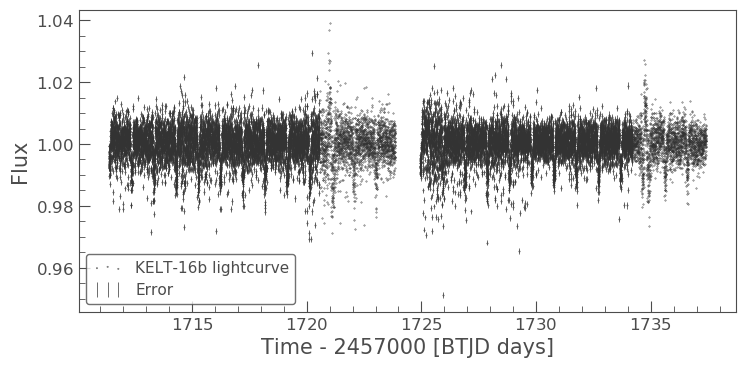

In [6]:
if (True):
            # Print the first aperture value to compare with expectation
            print(aperture_sums[0])
            # Construct a lightcurve object using the computed series
            lc_june = lk.TessLightCurve(time = tess_bjds, flux = np.array(aperture_sums), flux_err = err, flux_unit = None, time_format = 'btjd', time_scale = 'tdb', centroid_col = None, centroid_row = None, quality = None, quality_bitmask = None, cadenceno = None, sector = tpf.sector, camera = tpf.camera, ccd = tpf.ccd, targetid = 236445129, ra = tpf.ra, dec = tpf.dec, label = 'KELT-16b')
            
            #print(len(tess_bjds), len(aperture_sums), len(err))
            #print(lc_june.flux.shape, lc_june.time.shape, lc_june.flux_err.shape)
            
            # Print the new lightcurve object properties for record
            lc_june.show_properties()
            # Clean the series of outliers > 7 sigma from the series
            lc_june = lc_june.remove_outliers(sigma=7)
            # Remove the downward flux trend expirienced by Tess throught an orbit
            lc_june = lc_june.flatten(window_length=1001)
            
            # Produce a scatter with error bar plot of the lightcurve
            ax = lc_june.errorbar(label = 'Error', title = 'KELT-16b Lightcurve With Flux Error : Normalized')
            lc_june.scatter(ax = ax, s = 0.1, label = 'KELT-16b lightcurve')
            



The flux scales have been normalized for convenience. The light curve is then stored in a fits table using the Astropy.table and Astropy.io libraries, the fits table is then exported to undergo peer review and later analysis.

In [7]:
# Store the lightcurve flux column
aperature_sums = lc_june.flux 

# Construct Astropy Table column objects that contain the flux values and their associated times
c1 = fits.Column(name='APERTURE_SUM', array = aperture_sums, format='D')
c2 = fits.Column(name='TIME', array = tess_bjds, format='D')
# Combine the columns into a fits HDU (Header Data Unit)
table_hdu = fits.BinTableHDU.from_columns([c1, c2])

# Produce the fits Header
hdr = fits.Header()
# Set the fits Header as the Primary HDU
h_primary = fits.PrimaryHDU(header=hdr)
# Combine into a single fits object
hdul = fits.HDUList([h_primary, table_hdu])

# Write the fits object to a file in the root of the python pipeline
hdul.writeto('236445129_june_lc.fits', overwrite = True)

(18757,)


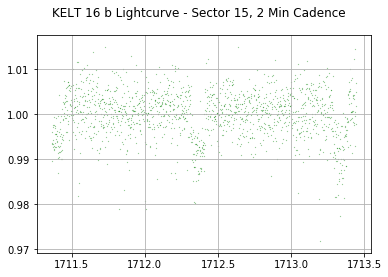

In [8]:
# Start figure and axis.
fig, ax = plt.subplots()
print(tess_bjds.shape)

# Let's define a title for the figure.
fig.suptitle("KELT 16 b Lightcurve - Sector 15, 2 Min Cadence")
ax.scatter(lc_june.time[0:1500], lc_june.flux[0:1500], c = 'g', marker = '.', s = 0.1)
# ax.scatter(tess_bjds, aperture_sums, c = 'g', marker = '.', s = 0.1)
ax.grid()
plt.show()


The period of KELT-16b is obtained by converting the lightcurve object into a periodogram. A periodogram is an element of signal processing that quantizes spectral density of a signal, it can be used to analyze the power spectrum of our lightcurve to extract the frequency of transit and period of orbit. The method of production for constructing a periodogram used is the Box Least Squares periodogram method. Using the results of the periodogram, a transit model using the power and period is constructed. The gap between 1724 and 1725 is due to TESS downtime midway through sector observing. 

No period specified. Using period at max power
No duration specified. Using duration at max power
No transit time specified. Using transit time at max power


0.019086292031123244
1.037988024037055 1 / d
0.963402252090243 d
0.0028713443868610055
0.25 d
0.4476505554676333


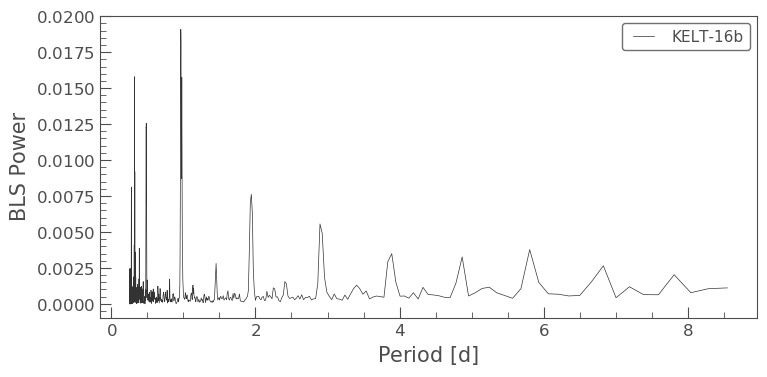

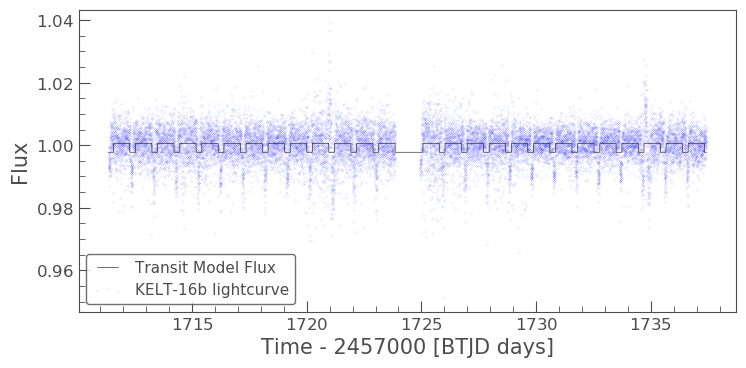

In [9]:
lc_periodogram = lc_june.to_periodogram(method = 'bls')
lc_periodogram.plot()
# lc_bin = lc_periodogram.bin(binsize = 1.5, method = 'median')
# lc_bin.plot()
#lc_flat = lc_periodogram.flatten()
#lc_smooth = lc_flat.smooth()
print(lc_periodogram.max_power)
print(lc_periodogram.frequency_at_max_power)
#print(lc_periodogram.period)
print(lc_periodogram.period_at_max_power)
print(lc_periodogram.depth_at_max_power)
print(lc_periodogram.duration_at_max_power)
print(lc_periodogram.transit_time_at_max_power)
# print(lc_periodogram.compute_stats())
# lc_periodogram.show_properties()
lc_fit = lc_periodogram.get_transit_model()
# lc_bin_fit = lc_bin.get_transit_model()
ax = lc_fit.plot()
lc_june.scatter(ax = ax, s = 0.01,marker = '.', c = 'b', label = 'KELT-16b lightcurve')
# lc_bin_fit.plot(ax = ax)


The period obtained is 0.963402252090243 days with a corresponding transit frequency of 1.037988024037055 transits per day. 

The base mean flux is  1.000874363134604 +/- 0.004645882585325493
The transit mean flux is  0.991709249665481 +/- 0.004075022399839921


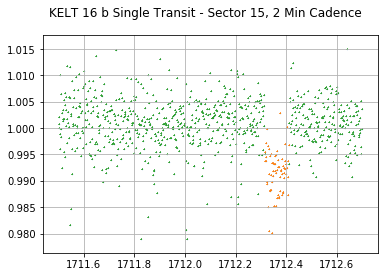

In [10]:
# Baseline time 1712.0 - 1712.3 1712.43-1712.6
# Transit time 1712.303 - 1712.311
temp_trans_time = lc_june.time[ [lc_june.time > 1711.5] ]
temp_trans_flux = lc_june.flux[ [lc_june.time > 1711.5] ]

samp_trans_time = temp_trans_time[ [temp_trans_time < 1712.7] ]
samp_trans_flux = temp_trans_flux[ [temp_trans_time < 1712.7] ]
# print(samp_trans_time.shape)
# print(samp_trans_flux.shape)

temp_trans_flux = samp_trans_flux[[samp_trans_time > 1712.315]]
temp_trans_time = samp_trans_time[[samp_trans_time > 1712.315]]
trans_flux = temp_trans_flux[[temp_trans_time < 1712.41]]
trans_time = temp_trans_time[[temp_trans_time < 1712.41]]

base_flux = samp_trans_flux[[samp_trans_time < 1712.315]]
base_time = samp_trans_time[[samp_trans_time < 1712.315]]
base_flux = np.append(base_flux, np.array(samp_trans_flux[[samp_trans_time > 1712.41]]))
base_time = np.append(base_time, np.array(samp_trans_time[[samp_trans_time > 1712.41]]))

# print(trans_time.shape)
# print(trans_flux.shape)
# print(base_time.shape)
# print(base_flux.shape)
# Start figure and axis.
fig, ax = plt.subplots()
fig.suptitle("KELT 16 b Single Transit - Sector 15, 2 Min Cadence")
ax.scatter(samp_trans_time, samp_trans_flux, s = 0.1, marker = 'o')
ax.scatter(trans_time, trans_flux, s = 1, marker = '+')
ax.scatter(base_time, base_flux, s = 1, marker = '+')
ax.grid()

base_mean_flux = np.mean(base_flux)
trans_mean_flux = np.mean(trans_flux)
base_mean_flux_err = np.std(base_flux)
trans_mean_flux_err = np.std(trans_flux)
print('The base mean flux is ', base_mean_flux, '+/-', base_mean_flux_err)
print('The transit mean flux is ', trans_mean_flux, '+/-', trans_mean_flux_err)


To obtain the radius of the planet a ratio between the change in flux and the square of the ratio of the planet to its host stars size. The comparison is made in units of solar radii but is converted for comparison. The error estimates are contributed from the spread of the data computing flux obtained as a standard deviation value, the value is then run through the radius calculation using the propagation of error for a product-quotient system. $\delta z = \sqrt{{{\delta x}/{x}}^{2}+{{\delta y}/{y}}^{2}} $ 

In [11]:
delta_flux = (base_mean_flux - trans_mean_flux) 

# print(delta_flux)

r_star = 1.414 # Solar radii
r_star_err = 0.064
r_planet = r_star * np.sqrt(delta_flux / base_mean_flux)
# r_planet_err = r_planet * np.sqrt((np.sqrt(base_mean_flux_err **2 + trans_mean_flux_err**2)/(delta_flux))**2 + (r_star_err/r_star)**2)
r_planet_err = r_planet * np.sqrt((base_mean_flux_err/base_mean_flux) **2 + (trans_mean_flux_err / trans_mean_flux) **2 + (r_star_err/r_star)**2)

print('The ratio between the planet and the stars radius is : ', r_planet/r_star)
print('The radius of the planet is ', r_planet, '+/-', r_planet_err, ' solar radii')

The ratio between the planet and the stars radius is :  0.09569277314661231
The radius of the planet is  0.1353095812293098 +/- 0.006181515453229077  solar radii


In [12]:
r_sun = 695842 # km
r_earth = 6371 # km
r_jupiter = 69911 # km

r_planet_km = r_planet * r_sun
r_planet_err_km = r_planet_err * r_sun
r_planet_j = r_planet_km / r_jupiter
r_planet_err_j = r_planet_err_km / r_jupiter
r_planet_e = r_planet_km / r_earth
r_planet_err_e = r_planet_err_km / r_earth
print('The radius of the planet is ', r_planet_km, '+/-', r_planet_err_km, ' kilometers ')
print('The radius of the planet is ', r_planet_j, '+/-', r_planet_err_j, ' Jupiter radii')
print('The radius of the planet is ', r_planet_e, '+/-', r_planet_err_e, ' Earth radii')

The radius of the planet is  94154.0896217654 +/- 4301.358076005828  kilometers 
The radius of the planet is  1.3467707459736722 +/- 0.061526198681263716  Jupiter radii
The radius of the planet is  14.778541770799778 +/- 0.6751464567580957  Earth radii


The resulting radius classifies KELT-16b as a super-Jupiter, consistent with the previous measurements of 16.7364 +/- 0.77330 Earth radii [2], and 1.384 +0.089/-0.080 Jupiter radii [1]. While our measurement is within the spread of the standard measurements, a formal sum of all 27 transits may in the future bring the measured planetary radius into agreement with literature. The orbital characteristics of KELT-16b are obtained using Kepler's third law and adopting a stellar mass of 1.206 +/- 0.048 solar radii [2] and our transit period of 0.963402252090243 days

In [13]:
# ((G * M * T**2) / (4 * np.pi**2)) ** (1/3)
from astropy.constants import G
import astropy.constants as const
star_mass  = (u.solMass * 1.206).to(u.kg)
star_mass_err = (u.solMass * 0.048).to(u.kg)
transit_period = (0.963402252090243 * u.d).to(u.s)

semi_major_axis = ((G * star_mass * transit_period ** 2) / (4 * np.pi**2)) ** (1/3)
semi_major_axis = semi_major_axis.to(u.au)
semi_major_axis_err = semi_major_axis * (star_mass_err / star_mass)
print('The semi-major axis is ', semi_major_axis.value, '+/-', semi_major_axis_err.value, ' AU')
# print(transit_period)

The semi-major axis is  0.020319916677618798 +/- 0.0008087529025917929  AU


In [1] the period and semi-major axis are listed as 0.9689951 +/- 0.0000026 days and 0.02041 +/- 0.00028 AU, and [2] lists the same as 0.9689948 +/- 0.000024407 days and 0.0209 +/- 0.0015645 AU . Both values from literature are in agreement with our value of 0.9634022521 days and 0.0203199166 +/- 0.0008087529  AU. The values from literature and our values are made with the valid assumption that the planets orbit is not circular but elliptical. 

In [14]:
# Print the end time and total computing time
END_DATE_TIME = datetime.datetime.now()
print('\nEnding time: ', END_DATE_TIME)
print("Time elapsed: ", (END_DATE_TIME - START_DATE_TIME))


Ending time:  2019-12-04 00:18:27.398138
Time elapsed:  0:00:49.798946


The primary source of uncertainty comes from the spread of the flux and the uncertainty in values adopted from literature. A value of uncertainty for the period could not be obtained using the power spectrum periodogram method. Comparatively low uncertainty values on measurements made and values of period from literature show the effect of this shortfall is not significant. 

## Discussion

Because KELT-16b is an ultra short period hot super-Jupiter orbiting an F7 spectral class star at an easily accessible magnitude and with plenty of nearby comparison stars for differential photometry, KELT-16b is a good candidate for continuous observation from the community. The ultra short period we found at 0.9634022521 days would enable the collection of plenty of transits that would allow for the study of the change in period as the planet slowly spirals towards KELT-16's Roche limit [1]. JWST has the unique ability to follow up observations with spectroscopic measurements of KELT-16b's atmospheric density and composition, a proposition that would allow for the broad study of planetary atmosphere at a small orbital distance such as the measured semi-major axis of 0.0203199166 +/- 0.0008087529  AU. 

KELT-16 is within the neighbourhood of the eastern Veil nebula both in on sky appearance and distance, the possibility for secondary planets around KELT-16 that may be within the goldilock's zone presents a unique opportunity to possibly study the effects of supernovae on planetary systems. Traces of remnant material could be spectroscopically observed in the atmosphere of KELT-16 planets. 

Furthermore, a subtle sinusoidal signal can be observed in the baseline flux of KELT-16 with a period of roughly 6 days. The accepted age of KELT-16 puts it halfway through its life on the main sequence, thus short period reoccurring variability is well outside being a probably cause. The unidentified signal can also be observed by looking at the trend of transit depth. Due to the nature of the trend, a possible cause may be a secondary transiting light source as a companion star. Further analysis should give more insight into the unknown trend; if confirmed as another companion star other than the distant companion previously identified [1], it would have serious consequences for the dynamics of KELT-16b including an increase in effective flux being delivered to the planets surface. The trend may also be to blame for the slight under-measurement of the planets radius, a combined analysis of all 27 observed transits would then remedy the radius discrepancies and confirm the impact of the unknown signal on future observation.

Ground observation of KELT-16b should also be continued to fill in the time when TESS is not observing sector 15. The data we obtained in October 2019 will be further analyzed by applying adaptive aperture masking and further background reduction to account for the poor seeing conditions encountered.


*We further propose an official naming for the KELT-16 system, KELT-16 and its inner companion should be known as Mike for the unconfirmed companion and Ike for KELT-16. KELT-16b should be known as Tamale, due to its planetary characteristics being consistent with the hotness of the hot tamale candies associated with the Mike & Ike candies. The confirmed stellar companion would inherit the Mike name in the case that the unknown signal is not an unconfirmed stellar companion, otherwise it should be known as peep to align with the Mike & Ike candy family naming scheme.*

## References
[1]: Thomas E. Obert, Joseph E. Rodriguez, Knicole D Colon, et al. 	arXiv:1608.00618 [astro-ph.EP] https://arxiv.org/abs/1608.00618

[2]: Kelt survey, https://keltsurvey.org/planets/kelt-16b

[3]: Gudmundur Stefansson, Astrobites | Sep 20, 2016, "KELT-16b: a new benchmark for future exoplanet atmosphere studies", https://astrobites.org/2016/09/20/kelt-16b-a-new-benchmark-for-future-exoplanet-atmosphere-studies/

[4]: Data Validation report for TESS ID 236445129 sectors 15-15 21-sep-2019 11:23:33 Z

## Appendix


---

![KELT-16b ](sample_transit_time_out.png)

A zoomed in view of the measured transit.

---
---

![KELT-16b ](Sector_15_FFI_pix.png)

A sample FFI from TESS sector 15 - KELT-16 is unidentifiable at this scale.

---
---

![KELT-16b ](KELT16b_14.png)

A sample image of the data taken on 2019-10-09+10 - the issue with telescope seeing is readily apparent which prevented conventional methods from extracting a usable light curve profile.

---